In [4]:
pip install --upgrade keras


Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ElTree
import re, h5py, itertools, math, glob, zipfile, os
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import log_loss, auc, roc_curve
from tensorflow.keras import layers
from tensorflow.keras.layers import Masking
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, TimeDistributed
from keras.layers import LSTM
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.python.client import device_lib
from lxml import etree
from gensim.models import Word2Vec

# %matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
plt.style.use('ggplot')
seed = 42

import warnings
warnings.filterwarnings(action = "ignore")

# Some additional & preparative actions

In [9]:



import pandas as pd

# Set global float formatting
pd.options.display.float_format = '{:.3f}'.format

# Example DataFrame
df = pd.DataFrame({
    'A': [1.234567, 2.345678, 3.456789],
    'B': [4.567890, 5.678901, 6.789012]
})

print(df)


      A     B
0 1.235 4.568
1 2.346 5.679
2 3.457 6.789


In [10]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'accuracy' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'accuracy' in s and 'val' in s]
    
    plt.figure(figsize = (12, 5), dpi = 100)
    COLOR = 'gray'
    
    plt.rc('legend', fontsize = 14)   # legend fontsize
    plt.rc('figure', titlesize = 12)  # fontsize of the figure title
        
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1, len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.subplot(1, 2, 1)
    plt.subplots_adjust(wspace = 2, hspace = 2)
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.titlecolor'] = 'black'
    plt.rcParams['axes.labelcolor'] = COLOR
    plt.rcParams['xtick.color'] = COLOR
    plt.rcParams['ytick.color'] = COLOR
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b-o',
                 label = 'Train (' + str(str(format(history.history[l][-1],'.4f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g',
                 label = 'Valid (' + str(str(format(history.history[l][-1],'.4f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend(facecolor = 'gray', loc = 'best')
    plt.grid(True)
    plt.tight_layout()
    
    ## Accuracy
    plt.subplot(1, 2, 2)
    plt.subplots_adjust(wspace = 2, hspace = 2)
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.titlecolor'] = 'black'
    plt.rcParams['axes.labelcolor'] = COLOR
    plt.rcParams['xtick.color'] = COLOR
    plt.rcParams['ytick.color'] = COLOR
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b-o',
                 label = 'Train (' + str(format(history.history[l][-1],'.4f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g',
                 label = 'Valid (' + str(format(history.history[l][-1],'.4f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(facecolor = 'gray', loc = 'best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

class B_Generator(object):
    def __init__(self, BZ, XX, YY, ohe):
        self.BZ = BZ
        self.n_b = int(math.floor(np.shape(XX)[0] / BZ))
        self.b_index = [a * BZ for a in range(0, self.n_b)]
        self.XX = XX
        self.YY = YY
        self.ohe = ohe
        
    def __iter__(self):
        for var_0 in itertools.cycle(self.b_index):
            YY = self.YY[var_0 : (var_0 + self.BZ)]
            ohe_Y = self.ohe.transform(YY.reshape(len(YY), 1))
            yield (self.XX[var_0 : (var_0 + self.BZ),], ohe_Y)

# Reading the Dataset


In [8]:
number = 2

if zipfile.is_zipfile('DataSets.zip'):
  file_1 = zipfile.ZipFile('DataSets.zip', 'r')
else:
  print('Type file isn`t ZIP')

name_dataset = file_1.namelist()[number]
file_1.extract(name_dataset)
print("File", name_dataset, "has been read")

File TestbedSunJun13Flows.xml has been read


# Dataset manipulations

This code section will help us to make the following actions:

parse the unzipped file of the dataset from XML
convert it to DataFrame to make it more convenient to use
delete some redundant columns from the DataFrame
check this DataFrame for data duplicates
sort the values of the dataset
add two additional columns
rename the columns which have quite long names


In [15]:
import zipfile
import os
import xml.etree.ElementTree as ElTree
import pandas as pd
import numpy as np

# Step 1: Extract the ZIP file
zip_path = "Datasets.zip"  # Path to your ZIP file
extract_to = "extracted_datasets"  # Directory to extract the files

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Step 2: Locate the XML file
xml_files = [f for f in os.listdir(extract_to) if f.endswith('.xml')]
if xml_files:
    name_dataset = os.path.join(extract_to, xml_files[0])
    print(f"Using XML file: {name_dataset}")
else:
    raise FileNotFoundError("No XML files found in the extracted ZIP.")

# Step 3: Parse the XML file
tree_set = ElTree.parse(name_dataset)
root_tree_set = tree_set.getroot()

result = []

# Extract variable from the root tree's first item's attribute
var_1 = root_tree_set.items()[0][1][:-4]

# Process XML nodes and build the result list
for item in root_tree_set.findall(var_1):
    result.append({node.tag: node.text for node in item.iter()})

# Convert the result to a DataFrame
dSET = pd.DataFrame(result)

# DataFrame processing
dSET = dSET.drop(dSET.columns[[0]], axis=1)
dSET = dSET.drop_duplicates()
dSET = dSET.sort_values('startDateTime')

# Create a new column for sequence
dSET['IPs_sequence'] = dSET['source'] + '_' + dSET['destination'] + '_' + dSET['startDateTime'].str[:13]

# Create a new column for port resolution
dSET['res_port'] = np.where(dSET.destinationPort <= dSET.sourcePort,
                            dSET['destinationPort'],
                            dSET['sourcePort'])

# Rename columns for convenience
dSET = dSET.rename(columns={
    'totalSourceBytes': 'totSB',
    'totalDestinationBytes': 'totDB',
    'totalDestinationPackets': 'totDP',
    'totalSourcePackets': 'totSP',
    'sourcePayloadAsBase64': 'sourB64',
    'sourcePayloadAsUTF': 'sourUTF',
    'destinationPayloadAsBase64': 'destB64',
    'destinationPayloadAsUTF': 'destUTF',
    'direction': 'direct',
    'sourceTCPFlagsDescription': 'sourTCPFd',
    'destinationTCPFlagsDescription': 'destTCPFd',
    'protocolName': 'pName',
    'sourcePort': 'sPort',
    'destination': 'dest',
    'destinationPort': 'dPort'
})

print("Preparation process has been finished")


Using XML file: extracted_datasets\TestbedMonJun14Flows.xml
Preparation process has been finished


In [16]:
dSET.shape, dSET.columns

((171350, 21),
 Index(['appName', 'totSB', 'totDB', 'totDP', 'totSP', 'sourB64', 'destB64',
        'destUTF', 'direct', 'sourTCPFd', 'destTCPFd', 'source', 'pName',
        'sPort', 'dest', 'dPort', 'startDateTime', 'stopDateTime', 'Tag',
        'IPs_sequence', 'res_port'],
       dtype='object'))

The dataset contains a lot of objects (rows) depending on a selected file, for each of which 20 features are set (columns), including 1 target feature (Tag) and two additional columns (IPs_sequence and res_port).







Input features (column names):

appName - name of the application that participated in this data collection.

totalSourceBytes, totSB - the amount of data received in bytes from Source.

totalDestinationBytes, totDB - the amount of data sent in bytes to Destination.

totalDestinationPackets, totDP - the amount of data sent in packets to Destination.

totalSourcePackets, totSP - the amount of data received in packets from Source.

sourcePayloadAsBase64, sourB64 - source payload in Base64 code.

sourcePayloadAsUTF, sourUTF - source payload in another UTF-8 (Unicode Transformation Format) 8-bit code.

destinationPayloadAsBase64, destB64 - destination payload in Base64 code.

destinationPayloadAsUTF, destUTF – destination payload in another UTF-8 (Unicode Transformation Format) 8-bit code.

direction, direct - data transferring direction, for instance, local-to-local (L2L), local-to-remote (L2R), remote-to-local (R2L), remote-to-remote (R2R).

sourceTCPFlagsDescription, sourTCPFd - sources description of the TCP flags, for instance, ACKnowledgement, A: flag is used to acknowledge the 

successful receipt of packets; Push, P flag, like the Urgent flag: exists to ensure that the data is given the priority (that it deserves) and is 

processed at the sending or receiving end; Final, F flag: available is the FIN flag, standing for the word FINished, etc.

destinationTCPFlagsDescription, destTCPFd - destination description of the TCP flags, description see above.

source – source IP-address.

protocolName, pName – name of used protocol.

sourcePort, sPort – number of source port.

desctination, dest – destination IP-address.

desctinationPort, dPort – number of destination port.

startDateTime, stopDateTime – date & time of start and stop of data collection process.

Tag – a feature (desired target) value that will be used for prediction.

In [17]:
dSET.head(5)

,appName,totSB,totDB,totDP,totSP,sourB64,destB64,destUTF,direct,sourTCPFd,...,source,pName,sPort,dest,dPort,startDateTime,stopDateTime,Tag,IPs_sequence,res_port
0,Unknown_UDP,16076,0,0,178,None,None,None,L2R,N/A,...,192.168.5.122,udp_ip,5353,224.0.0.251,5353,2010-06-13T23:57:19,2010-06-14T00:11:23,Normal,192.168.5.122_224.0.0.251_2010-06-13T23,5353
1,HTTPImageTransfer,384,0,0,6,None,None,None,L2R,"F,A",...,192.168.2.111,tcp_ip,4435,206.217.198.186,80,2010-06-13T23:58:23,2010-06-14T00:01:24,Normal,192.168.2.111_206.217.198.186_2010-06-13T23,4435
2,DNS,171,642,4,2,None,None,None,L2L,N/A,...,192.168.4.119,udp_ip,4428,192.168.5.122,53,2010-06-13T23:58:31,2010-06-13T23:59:25,Normal,192.168.4.119_192.168.5.122_2010-06-13T23,4428
3,HTTPImageTransfer,384,0,0,6,None,None,None,L2R,"F,A",...,192.168.4.119,tcp_ip,3639,219.94.203.105,80,2010-06-13T23:58:31,2010-06-14T00:00:58,Normal,192.168.4.119_219.94.203.105_2010-06-13T23,3639
4,HTTPImageTransfer,186,128,2,2,None,None,None,L2R,"F,P,A",...,192.168.4.119,tcp_ip,3641,98.137.80.50,80,2010-06-13T23:58:31,2010-06-13T23:59:26,Normal,192.168.4.119_98.137.80.50_2010-06-13T23,3641


## Main pipeline


**I stage. Keys building.

Here you will build a set of keys by several columns and with the help of groupby method. Thus, we will count the number of unique attacks and form a sequence for the further research. Moreover, we will select one port by a boundary 10000 (i.e. if the port number is less than 10 000) and will use it in the method groupby.

In [19]:
## Build the sets (keys and sequences) in hour slices
print("Stage I. Keys building\n")
key = dSET.groupby('IPs_sequence')[['Tag', 'res_port']].agg({"Tag": lambda var_2: "%s" % ','.join([var_3 for var_3 in var_2]),
          "res_port" :lambda var_2: "%s" % ','.join([str(var_3) if int(var_3) < 10000 else "10000" for var_3 in var_2])})

print("Unique keys:\n" + str(key.count()))
attacks = [var_4.split(",") for var_4 in key.Tag.tolist()]
sequences = [var_4.split(",") for var_4 in key.res_port.tolist()]

Stage I. Keys building

Unique keys:
Tag         22658
res_port    22658
dtype: int64


## II stage. Label encoding.
On this stage, you will form two sets: the number of unique tokens for the labels encoding process and the number of sequences. After this step, we will collapse our sequences into one sequence by the method zip.

In [20]:
print("Stage II. Label encoding\n")
U_tokens = list(set([var_5 for var_6 in sequences for var_5 in var_6]))
print("Number of unique tokens :", len(U_tokens))
LE = LabelEncoder().fit(U_tokens)
sequences = [LE.transform(var_7).tolist() for var_7 in sequences]
sequences = [[var_6 + 1 for var_6 in var_5] for var_5 in sequences]
print("Number of sequences :", len(sequences))
sequence_attack = zip(attacks, sequences)

Stage II. Label encoding

Number of unique tokens : 4201
Number of sequences : 22658


## III stage. Sequences generating for the future model.
    
On this stage, you will form some additional sets which we can use to form standard X & Y sets for the further training process of our neuronet. Also, we set the size of the primary sequence.

By the help of the input number that you will enter below, you will define the size of the primary sequence. The number has to be in the range from 10 to 20, you can pick up the best value to obtain the best model.

In [22]:
print("Stage III. Sequences generating for the future model\n")
var_8 = np.float32(0)
len_sequence = len_sequence = 10 # it's just an example
print("Length of the primary sequence :", len_sequence)
seq_IDX, seq_X, seq_Y, seq_ATT = [], [], [], []
for var_10, (var_11, var_12) in enumerate(sequence_attack):
    sequence_1 = [np.float32(0)] * (len_sequence) + var_12
    sequence_2 = [np.float32(0)] * (len_sequence) + var_11
    for var_9 in range(len_sequence, len(sequence_1)):
        sequence_3 = sequence_1[(var_9 - len_sequence):(var_9)]
        var_14 = []
        for var_13 in sequence_3:
            try:
                var_14.append(var_13)
            except:
                var_14.append(var_8)
        seq_X.append(var_14)
        seq_Y.append(sequence_1[var_9])
        seq_IDX.append(var_10)
        seq_ATT.append(sequence_2[var_9])
print("Length of X & Y sets :", len(seq_X))

Stage III. Sequences generating for the future model

Length of the primary sequence : 10
Length of X & Y sets : 171350


## IV stage. One-hot-encoder initializing.

This section is dedicated to one-hot encoding. The advantage of One-Hot-Encoding is that the result is binary, not ordinal, and that everything is in orthogonal vector space. The downside is that the space can quickly explode for high power of the function and you start to fight the curse of dimensionality. By default, OneHotEncoder converts the data to a sparse matrix so as not to waste memory on storing numerous zeroes.

In [25]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

print("Stage IV. One-hot-encoder initializing\n")
OHE = OneHotEncoder(sparse_output=False, categories='auto').fit(np.unique(seq_Y).reshape(-1, 1))

X = np.array(seq_X)
print("Dimensionality size of set X :", X.shape)


Stage IV. One-hot-encoder initializing

Dimensionality size of set X : (171350, 10)


## V stage. Model building.

You are to create your own model at this stage.

The first layer of the model is Embedding layer, which can be used to create dense encoding of words (in our case it's 100 words) based on the input size of the defined vocabulary (in our case it's number of unique tokens + 1). Typically, sparse and dense word encodings denote coding efficiency.

Further, we use a few (you can change this number) pairs of layers: bidirectional LSTM & Dropout. You can choose the number of layers pairs yourself.

Using bidirectional LSTM will run your input in two ways: one from the past to the future and one from the future to the past (backwards). This distinguishes this approach from unidirectional LSTM which works in the opposite direction so you save information from the future. Thus, by using the two hidden states together, you can save information from both the past and the future at any time.

Dropout layer is used in neural networks to solve the problem of overfitting. Networks for training are obtained by dropping out neurons with probability p, so the probability that a neuron will remain in the network is 1 - p.

Dense layer is an ordinary tightly bonded layer of the neural network, where each neuron is connected to all inputs.

In [27]:
print("Stage V. Model building\n")
drop_level = 0.35 # You can choose a drop level yourself
N_neurons = 50   # You can choose the number of neurons yourself

model = Sequential()
model.add(layers.Embedding(output_dim = 100,
                    input_dim = len(U_tokens) + 1,
                    mask_zero = True))

model.add(layers.Bidirectional(LSTM(N_neurons, return_sequences = True)))
model.add(layers.Dropout(drop_level))

# model.add(layers.Bidirectional(LSTM(N_neurons, activation = "relu", return_sequences = False))
# model.add(layers.Dropout(drop_level))

model.add(layers.Bidirectional(LSTM(N_neurons, activation = "relu", return_sequences = False)))
model.add(layers.Dropout(drop_level))

model.add(layers.Dense(N_neurons, activation = "linear"))
model.add(layers.Dropout(drop_level))

model.add(layers.Dense(len(U_tokens), activation = "softmax"))

##YOUR CODE GOES HERE##.summary()

Stage V. Model building



In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## VI stage. Model compiling & fitting.¶

This stage allows you to train your model, but firstly, you should set some hyperparameters & other variable values, such as batch size, the number of epochs for training, the types of optimizer & loss function. You can change all or a part of them during your research. Fitting process takes some time.

Replace ##YOUR CODE GOES HERE## with your Python code.

In [34]:
import numpy as np
from tensorflow.keras.utils import Sequence

class B_Generator(Sequence):
    def __init__(self, batch_size, X, Y, encoder):
        self.batch_size = batch_size
        self.X = X
        self.Y = Y
        self.encoder = encoder
        self.n_b = int(np.ceil(len(X) / batch_size))  # Number of batches per epoch

    def __len__(self):
        # Returns the number of batches per epoch
        return self.n_b

    def __getitem__(self, index):
        # Generate a single batch of data
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, len(self.X))
        batch_X = self.X[start:end]
        batch_Y = self.Y[start:end]
        return batch_X, self.encoder.transform(batch_Y.reshape(-1, 1)).toarray()

    def on_epoch_end(self):
        # Optional: Shuffle data at the end of each epoch
        indices = np.arange(len(self.X))
        np.random.shuffle(indices)
        self.X = self.X[indices]
        self.Y = self.Y[indices]


## VII stage. Results visualization.






You see the results of training for the loss & accuracy.

Stage VI. Compile and fit the model

Epoch 1/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 38s 80ms/step - accuracy: 0.2834 - loss: 6.1825
Epoch 2/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 26s 78ms/step - accuracy: 0.3232 - loss: 5.2494
Epoch 3/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 25s 75ms/step - accuracy: 0.3330 - loss: 4.8788
Epoch 4/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 25s 74ms/step - accuracy: 0.3400 - loss: 4.5827
Epoch 5/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 25s 75ms/step - accuracy: 0.3413 - loss: 4.3523
Epoch 6/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 25s 75ms/step - accuracy: 0.3461 - loss: 4.1289
Epoch 7/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 25s 75ms/step - accuracy: 0.3490 - loss: 3.9583
Epoch 8/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 25s 75ms/step - accuracy: 0.3540 - loss: 3.8137
Epoch 9/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 25s 75ms/step - accuracy: 0.3558 - loss: 3.7067
Epoch 10/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 25s 76ms/step - accuracy: 0.3581 - loss: 3.6343
Stage VII. Results visualization



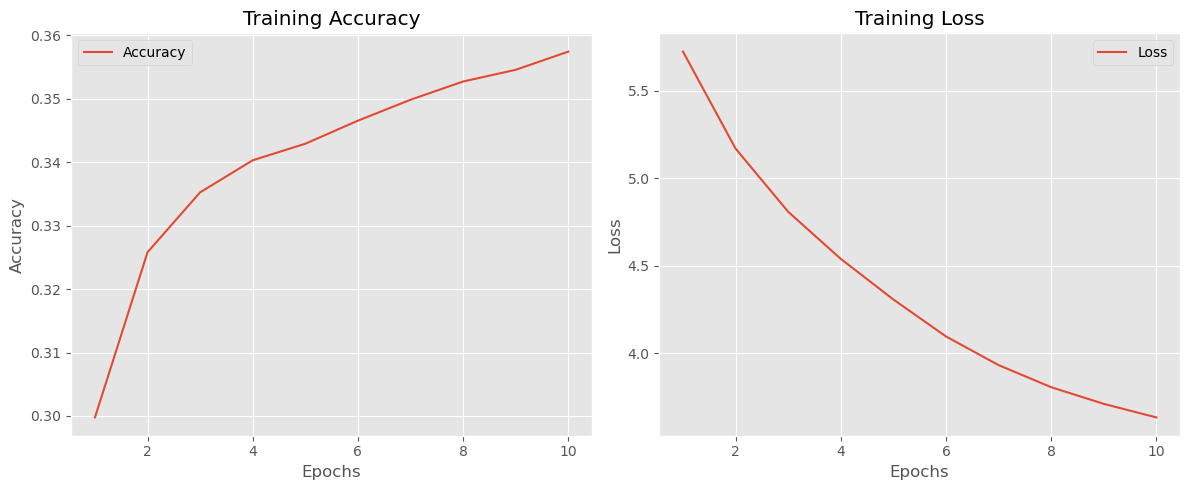

In [48]:
print("Stage VI. Compile and fit the model\n")

batch_size = 512
n_epochs = 10

optim = tf.keras.optimizers.Nadam()
loss_f = tf.keras.losses.CategoricalCrossentropy()

# Create the data generator
T_data = B_Generator(batch_size, np.asarray(X), np.asarray(seq_Y), OHE)

# Compile the model
model.compile(loss=loss_f,
              optimizer=optim,
              metrics=["accuracy"])

try:
    # Train the model and capture history
    history = model.fit(
        T_data,
        steps_per_epoch=T_data.n_b,
        epochs=n_epochs,
        verbose=1
    )
except Exception as e:
    print(f"Error during training: {e}")
    history = None

# Plot the results if training was successful
if history:
    print("Stage VII. Results visualization\n")
    plot_history(history)
else:
    print("Error: No training history available.")


Stage VII. Results visualization



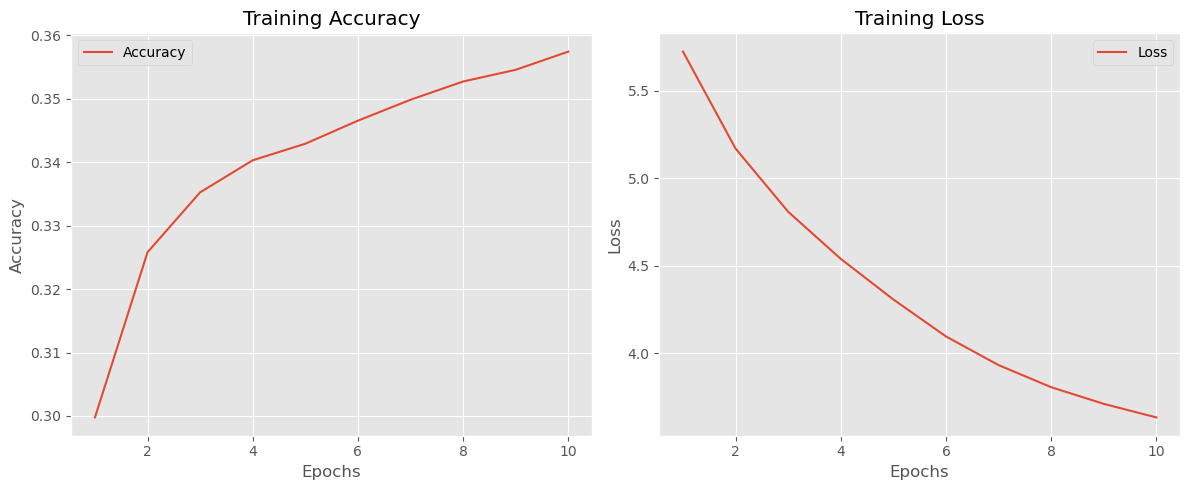

AttributeError: 'NoneType' object has no attribute 'history'

In [49]:
print("Stage VII. Results visualization\n")
plot_history(plot_history(history))

In [50]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Extract metrics from history
    acc = history.history.get('accuracy', [])
    loss = history.history.get('loss', [])
    epochs = range(1, len(acc) + 1)
    
    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()



## VIII stage. Model saving & prediction checking.¶

We still have two steps to do. The first is to save our trained model so that we can use it in the further research. The second is to check our saved model and try to make a prediction.

You can enter any name of your model for saving, but make sure that it is in quotes.

In [52]:
import os
print("Stage VIII. Model saving & prediction checking\n")

M_name = "My_model"
filepath = M_name + '.keras'  # Save using the new Keras format
tf.keras.models.save_model(model, filepath, include_optimizer=True, overwrite=True)

print("Size of the saved model:", os.stat(filepath).st_size, "bytes")


Stage VIII. Model saving & prediction checking

Size of the saved model: 9192513 bytes


In [54]:
# Load the saved model
model_L = tf.keras.models.load_model(filepath)

# Predict using the loaded model
predicts = model_L.predict(X, batch_size=batch_size)

# Output the dimensionality of the predictions
print("Dimensionality sizes of model predicts:", predicts.shape, "\n")
print("Compare with length of X & Y sets:\t", len(seq_X), "\nand with number of tokens:\t\t", len(U_tokens))


335/335 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step
Dimensionality sizes of model predicts: (171350, 4201) 

Compare with length of X & Y sets:	 171350 
and with number of tokens:		 4201
